In [1]:
import sys
sys.path.append('..') 
from model_architectures import *
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from collections import Counter
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# height, width = 10, 10
height, width = 64, 64

Using device: cuda


In [2]:
# Enable GPU usage for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
model = Autoencoder64()
model.to(device)

# %%  
# Read the CSV file with specified data types
data = pd.read_csv(f"../archive/ascii_character_classification_{height}_x_{width}.csv", header=0)

label_counts = Counter(data.iloc[:, 0])
print(label_counts)

Counter({0: 5000, 48: 525, 69: 523, 78: 523, 44: 515, 50: 509, 32: 509, 13: 508, 38: 508, 93: 507, 77: 506, 35: 504, 16: 503, 27: 501, 76: 501, 19: 500, 37: 499, 36: 497, 3: 495, 84: 494, 64: 493, 25: 493, 67: 492, 63: 490, 28: 488, 47: 487, 6: 487, 43: 486, 11: 486, 15: 485, 95: 485, 7: 484, 81: 484, 59: 483, 85: 482, 29: 481, 20: 481, 83: 478, 70: 477, 54: 477, 87: 477, 80: 475, 34: 475, 66: 474, 82: 473, 49: 472, 89: 472, 46: 472, 12: 470, 40: 469, 90: 469, 30: 469, 94: 469, 75: 468, 73: 468, 79: 468, 17: 468, 74: 468, 55: 467, 10: 466, 60: 466, 39: 464, 33: 464, 52: 463, 1: 463, 62: 463, 53: 463, 91: 463, 2: 461, 61: 460, 31: 460, 26: 460, 88: 460, 41: 457, 8: 457, 4: 455, 86: 454, 71: 453, 23: 451, 68: 451, 21: 451, 72: 450, 24: 450, 42: 450, 5: 448, 56: 447, 92: 447, 18: 445, 58: 445, 65: 444, 45: 439, 9: 437, 51: 436, 22: 434, 57: 427, 14: 427})


In [4]:
# Prepare the data
X = data.iloc[:, 1:].astype("float64")   # Features are all columns except the first one
y = data.iloc[:, 0].astype("float64")     # Labels are the first column

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Optionally, if you want to convert them back to pandas DataFrames:
train_data = pd.concat([y_train, X_train], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

In [5]:
print(chr(12+32))

,


In [6]:
train_labels = train_data.iloc[:, 0].values    
train_images = train_data.iloc[:, 1:].values 

test_labels = test_data.iloc[:, 0].values 
test_images = test_data.iloc[:, 1:].values 

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)


In [7]:
# Reshape the images to [batch_size, 1, height, width]
train_images_tensor = train_images_tensor.view(-1, 1, height, width)
test_images_tensor = test_images_tensor.view(-1, 1, height, width)

print(train_images_tensor.shape)
print(test_images_tensor.shape)

# Create DataLoader for the train and test datasets
batch_size = 256
train_dataset = TensorDataset(train_images_tensor, train_images_tensor)  # Autoencoder target is the same as input
test_dataset = TensorDataset(test_images_tensor, test_images_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Move the data to the GPU
train_images_tensor, test_images_tensor = train_images_tensor.to(device), test_images_tensor.to(device)


torch.Size([40000, 1, 64, 64])
torch.Size([10000, 1, 64, 64])


In [8]:
criterion = nn.MSELoss()  # For autoencoder, we use MSE loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed

# Compute Train Accuracy (for reconstruction, we can visualize the results)
def compute_reconstruction_loss(model, data_loader, device):
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            _, decoded = model(images)
            loss = criterion(decoded, images)
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

In [9]:
train_losses = []

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    epoch_losses = []

    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()

        # Move data to the GPU
        images = images.to(device)
        # print(images.shape)
        _, decoded = model(images)
        
        # print(decoded.shape)
        # Calculate loss between the input and the reconstructed image
        loss = criterion(decoded, images)
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())
        total_loss += loss.item()

    scheduler.step()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print('Training finished.')

Epoch [1/10], Loss: 0.0217
Epoch [2/10], Loss: 0.0100
Epoch [3/10], Loss: 0.0072
Epoch [4/10], Loss: 0.0057
Epoch [5/10], Loss: 0.0048
Epoch [6/10], Loss: 0.0039
Epoch [7/10], Loss: 0.0035
Epoch [8/10], Loss: 0.0033
Epoch [9/10], Loss: 0.0031
Epoch [10/10], Loss: 0.0030
Training finished.


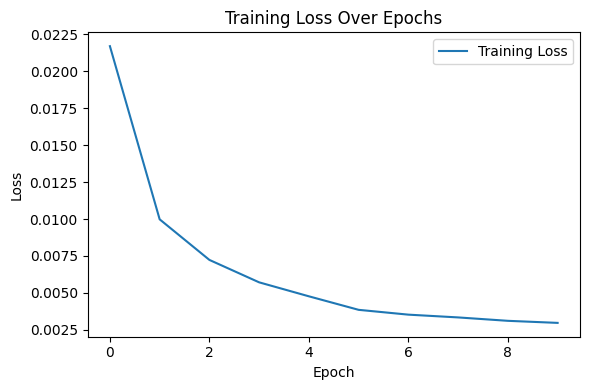

In [10]:
# Plotting training losses
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Save the model
torch.save(model.state_dict(), f'../artifacts/autoencoder_ascii_{height}_x_{width}.pth')


In [12]:
# Evaluate the model on the test data
model.eval()  # Set the model to evaluation mode

test_loss = compute_reconstruction_loss(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0034


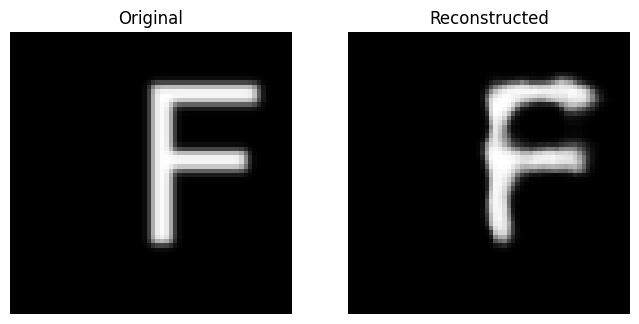

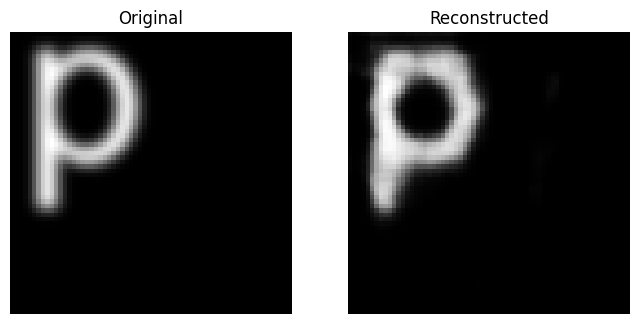

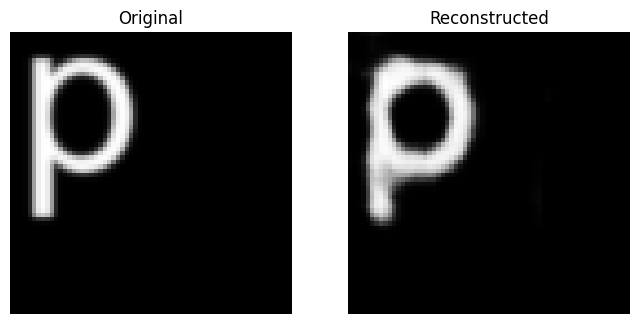

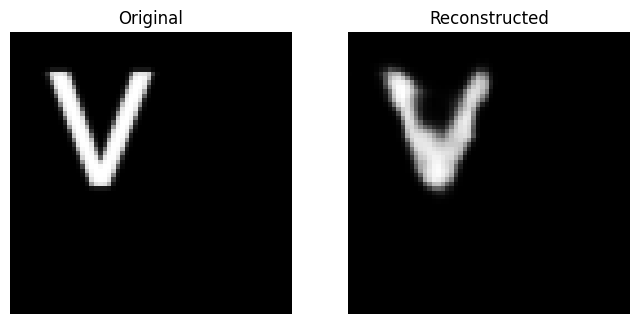

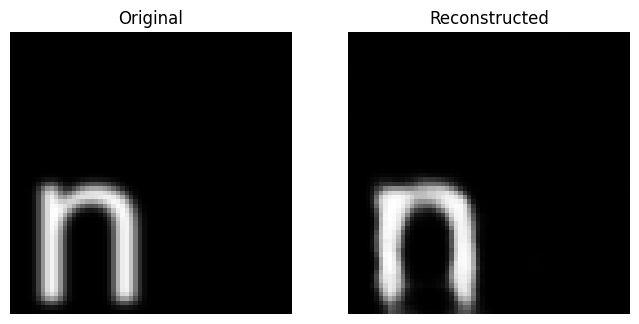

In [13]:
# Visualize some test results
import numpy as np

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        _, decoded = model(images)
        decoded_images = decoded.cpu().numpy()
        images = images.cpu().numpy()
        
        # Show the first few original and reconstructed images
        for j in range(5):
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].imshow(images[j, 0], cmap='gray')
            ax[0].set_title('Original')
            ax[0].axis('off')
            ax[1].imshow(decoded_images[j, 0], cmap='gray')
            ax[1].set_title('Reconstructed')
            ax[1].axis('off')
            plt.show()
        break